Import libraries 

In [5]:
# Add environment Packages paths to conda
import warnings
import pandas as pd
import numpy as np
warnings.simplefilter("ignore")

# Text preprocessing packages
import re # Regex Package
import regex
import emoji
import arabicstopwords.arabicstopwords as stp #more range of arabic stop words
from nltk.stem.isri import ISRIStemmer
import pyarabic.araby as araby

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from rank_bm25 import BM25Okapi
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

# Evaluation Packages
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ML Packages
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Save the model
import joblib

In [2]:
#df = pd.read_csv('Processed_Training_set.csv')
dfTest = pd.read_csv('6EmotionsTestData.csv')
#df.head()

In [3]:
dfTest.head()

,words,emotion
0,وشك ان صبح سبع نصف صبح وحد بءس,sadness
1,الي قدر اقل كره ولت عرف ندم,sadness
2,ادر صرخ زعج,sadness
3,حتج كءن يشر وقت رسم لوح نرفزهوقت فرح او زعل حد...,sadness
4,بجد ايه كونسب ال يخل قلع طرح يوم خطب او فرح او...,anger


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16014 entries, 0 to 16013
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   words    16014 non-null  object
 1   emotion  16014 non-null  object
dtypes: object(2)
memory usage: 250.3+ KB


In [4]:
dfTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1940 entries, 0 to 1939
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   words    1940 non-null   object
 1   emotion  1940 non-null   object
dtypes: object(2)
memory usage: 30.4+ KB


In [9]:
#print the number of null values in each column
df.isnull().sum()

words      0
emotion    0
dtype: int64

In [5]:
dfTest.isnull().sum()

words      0
emotion    0
dtype: int64

In [164]:
#to get the index of the null value
df[df['words'].isnull() == True]

,words,joy,sadness,anger,fear,disgust,surprise


In [11]:
#print the number of duplicated values 
df.duplicated().sum()

13

In [12]:
#print the rows which are duplicated
df[df['words'].duplicated() == True]

,words,emotion
11310,رعب,sadness
11322,سخط,anger
11431,متحمس,joy
11465,مرعب,sadness
11470,مستاء,sadness
11508,وجع,sadness
11800,جميل,joy
11917,سعيد,joy
11922,سلام,joy
12034,غريب,surprise


In [6]:
dfTest[dfTest['words'].duplicated() == True]

,words,emotion


In [14]:
#removing duplicated values
index = df[df['words'].duplicated() == True].index
df.drop(index, axis = 0, inplace = True)

In [15]:
df[df['words'].duplicated() == True]

,words,emotion


In [16]:
index = dfTest[dfTest['words'].duplicated() == True].index
dfTest.drop(index, axis = 0, inplace = True)

In [17]:
dfTest[dfTest['words'].duplicated() == True]

,words,emotion


In [74]:
#are there any stop words in the data?
arabic_stopwords = stp.stopwords_list()
len(stp.stopwords_list())

13465

In [18]:
df['stop_words'] = df['words'].apply(lambda x: len(set(x.split()) & set(arabic_stopwords)))
df.stop_words.value_counts()

stop_words
0     6453
1     2685
2     2272
3     1772
4     1171
5      751
6      428
7      212
8      126
9       55
10      39
11      12
12      10
14       4
13       2
27       1
15       1
Name: count, dtype: int64

In [174]:
dfTest['stop_words'] = dfTest['words'].apply(lambda x: len(set(x.split()) & set(arabic_stopwords)))
dfTest.stop_words.value_counts()

stop_words
1     466
2     442
3     345
0     285
4     274
5     192
6     139
7      62
8      44
9      29
10     14
11      4
12      3
13      1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

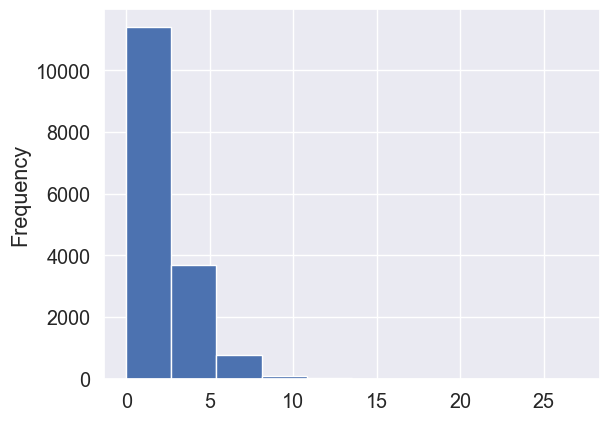

In [175]:
df['stop_words'].plot(kind= 'hist')

In [19]:
#to count the number of emojis in the dataset
def emoji_counter(sentence):
    return emoji.emoji_count(sentence)

df['emoji_count'] = df['words'].apply(lambda x: emoji_counter(x))
df.emoji_count.value_counts()[:10]

emoji_count
0    13267
1     1301
2      792
3      302
4      144
5       69
6       48
7       18
8       15
9       10
Name: count, dtype: int64

extract the emojis from every text


In [20]:
emojis_data = df[df['emoji_count'] > 0]

In [21]:
def extract_emoji(text):
    import emoji
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(emoji.distinct_emoji_list(char) for char in word):
            emoji_list.append(word)
    
    return emoji_list

In [22]:
emojis_data['emoji'] = emojis_data['words'].apply(lambda x: extract_emoji(x))
emojis_data['emoji'] = emojis_data['emoji'].apply(lambda x: ' '.join([word for word in x ]))

In [23]:
emojis_data

,words,emotion,emoji_count,emoji
0,#من_جمال_تويتر انو ادخل الوقت اللي ابيه واغرد ...,joy,4,😎 😂 🌚 💔
2,⁦مرحبا أنتي جميله وهناك شخص يحبك كوني سعيده دا...,joy,1,💘
7,#فرحه_قلبك_تتمثل_في رضا ربنا و حب الناس اللي ح...,joy,1,🙏
10,#فرحتي_نجاحي في مجتمعنا يرون أن إنجاب الذكر أم...,anger,1,✋
11,<&lt; و فجاه !! كرهت شخصا لم اتوقع ان اكرهه ي...,surprise,2,😯 💔
...,...,...,...,...
11155,أينعم مكانش حد فينا طايق حد اليوم ده وبيشتموا ...,joy,1,❤
11158,علي قدر الواحد يكون مبسوط و متفائل\nعلي قدر ما...,sadness,2,😢 💔
11159,??🌸 السعاده ليست حلم و لا وھم ولا بأمر محال بل...,joy,2,🌸 🌺
11160,#ريح_المدام\nالكبوت \n#بهجت : كبوت ايه ...تابو...,joy,3,😂 👌 💪


In [181]:
#find most repeated emojis
pd.Series(' '.join(emojis_data['emoji']).split()).value_counts()[:10]

😂     822
💔     502
😭     327
😍     235
❤     219
❤️    170
😠     148
😢     143
😡     128
😔      96
Name: count, dtype: int64

Cleaning

In [262]:
emojis = {
    "🙂":"ضحك",
    "🤣":"ضحك",
    "😂":"ضحك",
    "💔":"حزن",
    "🙂":"ضحك",
    "❤️":"حب",
    "❤":"حب",
    "😍":"حب",
    "😭":"حزن",
    "😢":"حزن",
    "😔":"حزن",
    "♥":"حب",
    "💜":"حب",
    "😅":"ضحك",
    "🙁":"حزن",
    "💕":"حب",
    "💙":"حب",
    "😞":"حزن",
    "😊":"فرح",
    "👏":"يصفق",
    "👌":"احسنت",
    "😴":"نوم",
    "😀":"ضحك",
    "😌":"حزن",
    "🌹":"وردة",
    "🙈":"حب",
    "😄":"ضحك",
    "😐":"محايد",
    "✌":"منتصر",
    "✨":"نجمه",
    "🤔":"تفكير",
    "😏":"يستهزء",
    "😒":"غضب",
    "🙄":"ملل",
    "😕":"غضب",
    "😃":"ضحك",
    "🌸":"وردة",
    "😓":"حزن",
    "💞":"حب",
    "💗":"حب",
    "😑":"غضب",
    "💭":"تفكير",
    "😎":"ثقة",
    "💛":"حب",
    "😩":"حزن",
    "💪":"عضلات",
    "👍":"موافق",
    "🙏🏻":"شكر",
    "😳":"قلق",
    "👏🏼":"تصفيق",
    "🎶":"موسيقي",
    "🌚":"صمت",
    "💚":"حب",
    "🙏":"شكر",
    "💘":"حب",
    "🍃":"سلام",
    "☺":"ضحك",
    "🐸":"ضفدع",
    "😶":"قلق",
    "✋🏻":"توقف",
    "😉":"فرح",
    "🌷":"حب",
    "🙃":"فرح",
    "😫":"حزن",
    "😨":"خوف",
    "🎼 ":"موسيقي",
    "🍁":"مرح",
    "🍂":"مرح",
    "💟":"حب",
    "😪":"حزن",
    "😆":"ضحك",
    "😣":"غضب",
    "☺️":"حب",
    "😱":"خوف",
    "😁":"ضحك",
    "😖":"استياء",
    "🏃🏼":"يجري",
    "😡":"غضب",
    "🚶":"يسير",
    "🤕":"مرض",
    "‼️":"تعجب",
    "🕊":"طائر",
    "👌🏻":"احسنت",
    "❣":"حب",
    "🙊":"مصدوم",
    "💃":"مرح",
    "💃🏼":"مرح",
    "😜":"مرح",
    "👊":"ضربة",
    "😟":"استياء",
    "💖":"حب",
    "😥":"حزن",
    "🎻":"موسيقي",
    "✒":"يكتب",
    "🚶🏻":"يسير",
    "💎":"الماس",
    "😷":"مرض",
    "☝":"واحد",
    "🚬":"تدخين",
    "💐" : "ورد",
    "🌞" : "شمس",
    "👆" : "الاول",
    "⚠️" :"تحذير",
    "🤗" : "احتواء",
    "✖️": "غلط",
    "📍"  : "مكان",
    "👸" : "ملكه",
    "👑" : "تاج",
    "✔️" : "صح",
    "💌": "قلب",
    "😲" : "مندهش",
    "💦": "ماء",
    "🚫" : "خطا",
    "👏🏻" : "ممتاز",
    "🏊" :"يسبح",
    "👍🏻": "تمام",
    "⭕️" :"دائره",
    "🎷" : "موسيقي",
    "👋": "تلويح باليد",
    "✌🏼": "علامه النصر",
    "🌝":"ضحك",
    "➿"  : "عقده مزدوجه",
    "💪🏼" : "قوي",
    "📩":  "تواصل معي",
    "☕️": "قهوه",
    "😧" : "غضب",
    "🗨": "رسالة",   
    "❗️" :"تعجب",
    "🙆🏻": "اشاره موافقه",
    "👯" :"اخوات",
    "©" :  "رمز",
    "👵🏽" :"سيده عجوزه",
    "🐣": "كتكوت",  
    "🙌": "تشجيع",
    "🙇": "شخص ينحني",
    "👐🏽":"ايدي مفتوحه",    
    "👌🏽": "بالظبط",
    "⁉️" : "استنكار",
    "⚽️": "كوره",
    "🕶" :"حب",
    "🎈" :"بالون",    
    "🎀":    "ورده",
    "💵":  "فلوس",   
    "😋":  "فرح",
    "😛":  "فرح",
    "😠":  "غضب",
    "✍🏻":  "يكتب",
    "🌾":  "ارز",
    "👣":  "اثر قدمين",
    "❌":"رفض",
    "🍟":"طعام",
    "👬":"صداقة",
    "🐰":"ارنب",
    "☂":"مطر",
    "⚜":"مملكة فرنسا",
    "🐑":"خروف",
    "🗣":"صوت مرتفع",
    "👌🏼":"احسنت",
    "☘":"مرح",
    "😮":"خوف",
    "😦":"خوف",
    "⭕":"الحق",
    "✏️":"قلم",
    "ℹ":"معلومات",
    "🙍🏻":"رفض",
    "⚪️":"نضارة نقاء",
    "🐤":"حزن",
    "💫":"مرح",
    "💝":"حب",
    "🍔":"طعام",
    "❤︎":"حب",
    "✈️":"سفر",
    "🏃🏻‍♀️":"يسير",
    "🍳":"ذكر",
    "🎤":"مايك غناء",
    "🎾":"كره",
    "🐔":"دجاجة",
    "🙋":"سؤال",
    "📮":"بحر",
    "💉":"دواء",
    "🙏🏼":"شكر",
    "💂🏿 ":"حارس",
    "🎬":"سينما",
    "♦️":"مرح",
    "💡":"قكرة",
    "‼":"تعجب",
    "👼":"طفل",
    "🔑":"مفتاح",
    "♥️":"حب",
    "🕋":"كعبة",
    "🐓":"دجاجة",
    "💩":"معترض",
    "👽":"فضائي",
    "☔️":"مطر",
    "🍷":"عصير",
    "🌟":"نجمة",
    "☁️":"سحب",
    "👃":"معترض",
    "🌺":"مرح",
    "🔪":"سكينة",
    "♨":"سخونية",
    "👊🏼":"ضرب",
    "✏":"قلم",
    "🚶🏾‍♀️":"يسير",
    "👊":"ضرب",
    "◾️":"وقف",
    "😚":"حب",
    "🔸":"مرح",
    "👎🏻":"لا يعجبني",
    "👊🏽":"ضربة",
    "😙":"حب",
    "🎥":"تصوير",
    "👉":"جذب انتباه",
    "👏🏽":"يصفق",
    "💪🏻":"عضلات",
    "🏴":"اسود",
    "🔥":"حريق",  
    "😬":"خوف",   
    "👊🏿":"يضرب",    
    "🌿":"ورقه شجره",     
    "✋🏼":"كف ايد",    
    "👐":"ايدي مفتوحه",      
    "☠️":"رعب",     
    "🎉":"يهنئ",      
    "🔕" :"صامت",
    "😿":"حزن",      
    "☹️":"حزن",     
    "😘" :"حب",     
    "😰" :"خوف و حزن",
    "🌼":"ورده",      
    "💋":"بوسه",
    "👇":"لاسفل",     
    "❣️":"حب",     
    "🎧":"سماعات",
    "📝":"يكتب",      
    "😇":"سعيد",      
    "😈":"رعب",      
    "🏃":"يجري",      
    "✌🏻":"علامه النصر",    
    "🔫":"يضرب",      
    "❗️":"تعجب",
    "👎":"غير موافق",      
    "🔐":"قفل",      
    "👈":"لليمين",
    "™":"رمز",    
    "🚶🏽":"يتمشي",    
    "😯":"متفاجأ",  
    "✊":"يد مغلقه",    
    "😻":"اعجاب",    
    "🙉" :"قرد",    
    "👧":"طفله",     
    "🔴":"دائره حمراء",      
    "💪🏽":"قوه",     
    "💤":"نوم",     
    "👀":"حيره",     
    "✍🏻":"يكتب",  
    "❄️":"تلج",
    "💀":"رعب",   
    "😤":"غضب",      
    "🖋":"قلم",      
    "🎩":"كاب",      
    "☕️":"قهوه",     
    "😹":"ضحك",     
    "💓":"حب",      
    "☄️ ":"نار",     
    "👻":"رعب",
    "🤮":"مقرف",
    "🤢":"مقرف",
    "🤪":"مرح",
    "🥴":"تعب",
    "🤧":"مرض",
    "🤒":"مرض",
    "🤕":"مرض",
    "🤑":"مرح",
    "🤐":"صمت",
    "🤫":"صمت",
    "🤭":"ضحك",
    "🧐":"تفكير",
    "🤓":"ذكاء",
    "🤩":"مرح",
    "🥳":"مرح",
    "🥺":"حزن",
    "🤥":"كذب",
    "🤔":"تفكير",
    "🤗":"مرح",
    "🥰":"مرح",
    "🤍":"حب",
    "🤲":"دعاء",
    "󾌴":"",
    "🤦":"الم",
    "🤷‍":"قلق",
    "🤚":"يد",
    "🦋":"مرح",
    "🥇":"فوز",
    }

emoticons_to_words = {
    ":))" : "ضحك",
    "((:" : "ضحك",
    ":)" : "ضحك",
    "(:" : "ضحك",
    ":(" : "حزن",
    "):" : "حزن",
    "xD" : "ضحك",
    ":=(": "يبكي",
    ":'(": "حزن",
    ":'‑(": "حزن",
    "XD" : "ضحك",
    ":D" : "ضحك",
    "♬" : "موسيقي",
    "♡" : "حب",
    "☻"  : "ضحك",
    }

## Functions

In [3]:
def remove_stop_words(text):
    arabic_stopwords = stp.stopwords_list()
    Text=[i for i in str(text).split() if i not in arabic_stopwords]
    return " ".join(Text)

def lemmatize_arabic_Iris(text):
    stemmer = ISRIStemmer()
    text=[stemmer.stem(y) for y in text.split()]
    return " " .join(text)

def normalizeArabic(text):
    text = text.strip()
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    
    #remove repetetions
    text = re.sub("[إأٱآا]", "ا", text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('ييي', 'ي')
    text = text.replace('اا', 'ا')

    #Remove extra whitespace
    text = re.sub('\s+', ' ', text)
    
    #Remove longation
    text = re.sub(r'(.)\1+', r"\1\1", text) 
    
    #Strip vowels from a text, include Shadda.
    text = araby.strip_tashkeel(text)
    
    #Strip diacritics from a text, include harakats and small lettres The striped marks are
    text = araby.strip_diacritics(text)
    text=''.join([i for i in text if not i.isdigit()])
    return text

def Removing_non_arabic(text):
    text = re.sub('[A-Za-z]+',' ',text)
    return text

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def Removing_punctuations(text):
    # Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"0123456789\\A-Za-z•—"""), ' ', text)
    text = text.replace('؛',"", )
    
    # Remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\u200d"                 # zero-width joiner
                           u"\uFE0F"                 # variation selector-16
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string).strip()
                     
def replace_emoticon_with_text(text):
    for i in range (len(text)):
        message = text.iloc[i]
        seperarate_word = message.split(' ')
        text.iloc[i] = ""

        for word in seperarate_word:
            text.iloc[i] += emoticons_to_words.get(word, word) + " "

def replace_emojis_with_text(text):
    for i in range (len(text)):
            message = text.iloc[i]
            seperarate_word = regex.findall(r'\X', message)
            text.iloc[i] = ""

            for word in seperarate_word:
                if any(emoji.distinct_emoji_list(char)  for char in word):
                        text.iloc[i] += " " + emojis.get(word, word) + " "
                else:
                        text.iloc[i] +=  emojis.get(word, word) + ""

In [5]:
cleaned_data = pd.read_csv('6EmotionsTrainData.csv')

In [6]:
cleaned_data.head()

,words,emotion
0,من جمل يتر انو دخل وقت الل ابه غرد بلل ابه وم ...,joy
1,نره حدباء عمل يدل ان ثور عشءر كانت ولش هدم وصم...,anger
2,⁦مرحب انت جمل شخص يحب كون سعد داء عين ذهل بسم حب,joy
3,عود خطر علم في علم وعل سلم ايه شكح,joy
4,غرابيب سود لم تبع اري كثر نقم ودي تبع شان قده ...,anger


Removing duplicated values


In [164]:
num_of_duplications = cleaned_data.duplicated().sum()
index = cleaned_data[cleaned_data['words'].duplicated() == True].index
cleaned_data.drop(index, axis = 0, inplace = True)

#resetting the index of the data
cleaned_data.reset_index(drop=True, inplace = True)

In [165]:
#Before
num_of_duplications

13

In [7]:
#Ater
cleaned_data.duplicated().sum()

0

In [10]:
dfTest.duplicated().sum()

0

In [8]:
cleaned_data

,words,emotion
0,من جمل يتر انو دخل وقت الل ابه غرد بلل ابه وم ...,joy
1,نره حدباء عمل يدل ان ثور عشءر كانت ولش هدم وصم...,anger
2,⁦مرحب انت جمل شخص يحب كون سعد داء عين ذهل بسم حب,joy
3,عود خطر علم في علم وعل سلم ايه شكح,joy
4,غرابيب سود لم تبع اري كثر نقم ودي تبع شان قده ...,anger
...,...,...
13606,يود,anger
13607,يوم جزه,joy
13608,يوم قيم,sadness
13609,ءجر,joy


#### Replace emoticons with Text

In [169]:
replace_emoticon_with_text(cleaned_data.words)

In [170]:
replace_emoticon_with_text(dfTest.words)

### Replace each emoji with a text and remove any other emoji not in the list

In [171]:
replace_emojis_with_text(cleaned_data.words)

In [172]:
replace_emojis_with_text(dfTest.words)

In [173]:
#Remove any other emoji
cleaned_data.words=cleaned_data.words.apply(lambda text : remove_emoji(text))
dfTest.words=dfTest.words.apply(lambda text : remove_emoji(text))

In [40]:
#Before
df.iloc[0].words

'#من_جمال_تويتر انو ادخل الوقت اللي ابيه واغرد باللي ابيه وم في احد يعرفني ولله الحمد مرتاحه 😎 😂 🌚 💔'

In [41]:
#After
cleaned_data.iloc[0].words

'#من_جمال_تويتر انو ادخل الوقت اللي ابيه واغرد باللي ابيه وم في احد يعرفني ولله الحمد مرتاحه  ثقة   ضحك   صمت   حزن'

Removing Arabic stopwords


In [175]:
cleaned_data.words=cleaned_data.words.apply(lambda text : remove_stop_words(text))
dfTest.words=dfTest.words.apply(lambda text : remove_stop_words(text))

Removal of non-Arabic words

In [176]:
cleaned_data.words=cleaned_data.words.apply(lambda text : Removing_non_arabic(text))
dfTest.words=dfTest.words.apply(lambda text : Removing_non_arabic(text))

In [53]:
#Before
df.words.iloc[18]

'#الهيبة #نادين_نسيب_نجيم #ملكة_الهيبة ايواااا راحت عليكي يا عليا بلش الفلم معك @nadinenjeim  اسا بدن يحطوها تحت الامر الواقع 😦'

In [54]:
#After
cleaned_data.iloc[18].words

'#الهيبة #نادين_نسيب_نجيم #ملكة_الهيبة ايواااا راحت عليكي يا عليا بلش الفلم @  اسا بدن يحطوها الامر الواقع قلق'

Removing Diacritics

In [177]:
cleaned_data.words=cleaned_data.words.apply(lambda text : normalizeArabic(text))
dfTest.words=dfTest.words.apply(lambda text : normalizeArabic(text))

In [57]:
#Before
df.words.iloc[4]

'#غرابييب_سود\\nلم أتابعه لكن أرى الكثير ناقمين عليه .. ودي أتابعه على شان أنقده .. عمومًا أنا لا أثق في mbc.'

In [58]:
#After
cleaned_data.iloc[4].words

'#غرابيب_سود\\ لم اتابعه اري الكثير ناقمين .. ودي اتابعه شان انقده .. عموما اثق .'

Removal of numbers

In [178]:
cleaned_data.words=cleaned_data.words.apply(lambda text : Removing_numbers(text))
dfTest.words=dfTest.words.apply(lambda text : Removing_numbers(text))

In [60]:
#Before
df.words.iloc[8399]

'ممكن يعمي الحج تقسطلنا ال11سنة الي ضايليين  !؟ - يشعر بـالاستياء'

In [61]:
#After
cleaned_data.iloc[8399].words

'ممكن يعمي الحج تقسطلنا السنه الي ضايلين !؟ - يشعر بـالاستياء'

Removal of Links

In [179]:
cleaned_data.words=cleaned_data.words.apply(lambda text : Removing_urls(text))
dfTest.words=dfTest.words.apply(lambda text : Removing_urls(text))

In [66]:
#Before
df.words.iloc[807]

'??*قصة مأساوية لأسرة في جدة توفي أفرادها بالكامل بعد إصابتهم بـ “كورونا” (فيديو)🎥* https://ksa-wats.com/75390 هذه رسالة لكل مستهتر 😔'

In [67]:
#After
cleaned_data.iloc[807].words

'??*قصه ماساويه لاسره جده توفي افرادها بالكامل اصابتهم بـ “كورونا” (فيديو) تصوير * :// - . / رساله مستهتر حزن'

### Removing Punctuations

In [180]:
cleaned_data.words=cleaned_data.words.apply(lambda text : Removing_punctuations(text))
dfTest.words=dfTest.words.apply(lambda text : Removing_punctuations(text))

In [69]:
#After
cleaned_data.iloc[8595].words

'ادين الله حماس ارهابيه ارهبت الكيان الصهيوني ربع قرن يزيد تكون ارهابيه حماس ليست ارهابيه'

### Stemming using IRIS

In [182]:
cleaned_data.words=cleaned_data.words.apply(lambda text : lemmatize_arabic_Iris(text))
dfTest.words=dfTest.words.apply(lambda text : lemmatize_arabic_Iris(text))

In [183]:
cleaned_data

,words,emotion
0,من جمال تويتر انو ادخل الوقت اللي ابيه واغرد ب...,joy
1,مناره الحدباء العمل يدل ان ثوره عشاءر كانت ولا...,anger
2,⁦مرحبا انتي جميله شخص يحبك كوني سعيده داءما عي...,joy
3,عوده اخطر معلمين في العالم وعليكم السلام ايوه ...,joy
4,غرابيب سود لم اتابعه اري الكثير ناقمين ودي اتا...,anger
...,...,...
15989,يوم الاجازه,joy
15990,يوم القيامه,sadness
15991,ءثر,joy
15992,ءجر,joy


### Remove duplicate

In [ ]:
cleaned_data.duplicated().sum()
#Note that: duplicated value was found when we remove diacritics and non arabic words and punctuations and this because some rows in the dataset only contains stopwords or it contains one or two words and other reasons so, we have to remove the duplicated values again

1734

In [ ]:
dfTest.duplicated().sum()

3

In [ ]:
index = cleaned_data[cleaned_data['words'].duplicated() == True].index
cleaned_data.drop(index, axis = 0, inplace = True)

#resetting the index of the data
cleaned_data.reset_index(drop=True, inplace = True)

index = dfTest[dfTest['words'].duplicated() == True].index
dfTest.drop(index, axis = 0, inplace = True)

dfTest.reset_index(drop=True, inplace = True)

In [ ]:
cleaned_data.duplicated().sum()

0

In [ ]:
dfTest.duplicated().sum()

0

In [84]:
cleaned_data

,words,emotion
0,من جمل يتر انو دخل وقت الل ابه غرد بلل ابه وم ...,joy
1,نره حدباء عمل يدل ان ثور عشءر كانت ولش هدم وصم...,anger
2,⁦مرحب انت جمل شخص يحب كون سعد داء عين ذهل بسم حب,joy
3,عود خطر علم في علم وعل سلم ايه شكح,joy
4,غرابيب سود لم تبع اري كثر نقم ودي تبع شان قده ...,anger
...,...,...
13606,يود,anger
13607,يوم جزه,joy
13608,يوم قيم,sadness
13609,ءجر,joy


### Null values 

In [85]:
cleaned_data.isnull().sum()

words      0
emotion    0
dtype: int64

In [86]:
dfTest.isnull().sum()

words      0
emotion    0
dtype: int64

In [222]:
cleaned_data.dropna(inplace = True)
dfTest.dropna(inplace = True)

In [125]:
cleaned_data

,words,emotion
0,من جمل يتر انو دخل وقت الل ابه غرد بلل ابه وم ...,joy
1,نره حدباء عمل يدل ان ثور عشءر كانت ولش هدم وصم...,anger
2,⁦مرحب انت جمل شخص يحب كون سعد داء عين ذهل بسم حب,joy
3,عود خطر علم في علم وعل سلم ايه شكح,joy
4,غرابيب سود لم تبع اري كثر نقم ودي تبع شان قده ...,anger
...,...,...
13607,يود,anger
13608,يوم جزه,joy
13609,يوم قيم,sadness
13610,ءجر,joy


## Splitting the dataset into the Training set and Test set

In [224]:
#Multi-label
X_train = cleaned_data.words.values
y_train = cleaned_data[["joy","sadness","anger","fear", "disgust","surprise"]]

X_test = dfTest.words.values
y_test = dfTest[["joy","sadness","anger","fear", "disgust","surprise"]]

In [9]:
#Multi-class
X_train = cleaned_data.words.values
y_train = cleaned_data[["emotion"]]

X_test = dfTest.words.values
y_test = dfTest[["emotion"]]

In [215]:
print(X_train[:5])

['من جمل يتر انو دخل وقت الل ابه غرد بلل ابه وم احد عرف ولل حمد رتح ثقه ضحك صمت حزن'
 'نره حدباء عمل يدل ان ثور عشءر كانت ولش هدم وصم عار بجب دخل دعش صفق ذكر ارخ حشر ولل جبناء'
 '\u2066مرحب انت جمل شخص يحب كون سعد داء عين ذهل بسم حب'
 'عود خطر علم في علم وعل سلم ايه شكح'
 'غرابيب سود لم تبع اري كثر نقم ودي تبع شان قده عمو اثق']


In [216]:
print(y_train[:5])

  emotion
0     joy
1   anger
2     joy
3     joy
4   anger


## Word Embedding

### BM-25

In [13]:
class BM25Vectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, k1=1.5, b=0.75):
        self.k1 = k1
        self.b = b
        self.bm25 = None

    def fit(self, X, y=None):
        # Tokenize the documents
        tokenized_corpus = [doc.split(" ") for doc in X]
        # Initialize BM25 model
        self.bm25 = BM25Okapi(tokenized_corpus, k1=self.k1, b=self.b)
        return self

    def transform(self, X, y=None):
        # Tokenize the query/document
        tokenized_queries = [doc.split(" ") for doc in X]
        # Retrieve BM25 scores for each document-query pair
        bm25_scores = np.array([self.bm25.get_scores(query) for query in tokenized_queries])
        return bm25_scores

### Word2Vec

In [14]:
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, size=100, window=5, min_count=1, workers=10):
        self.size = size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.model = None

    def fit(self, X, y=None):
        # Tokenize documents
        tokenized_docs = [word_tokenize(doc.lower()) for doc in X]
        # Train Word2Vec model
        self.model = Word2Vec(tokenized_docs, vector_size=self.size, window=self.window,
                              min_count=self.min_count, workers=self.workers)
        return self

    def transform(self, X, y=None):
        # Transform documents to document vectors
        return np.array([
            np.mean([self.model.wv[word] for word in words if word in self.model.wv]
                    or [np.zeros(self.size)], axis=0)
            for words in [word_tokenize(doc.lower()) for doc in X]
        ])

def train_model_word2vec(model, data, targets):
    text_clf = Pipeline([
        ('vect', Word2VecVectorizer()),  
        ('clf', model)
    ])
    text_clf.fit(data, targets)
    return text_clf

In [10]:
#Creating a pipline using tf-idf for words embedding and different models.
def train_model_IDF(model, data, targets):
    text_clf = Pipeline([
        ('vect',TfidfVectorizer(encoding='utf-8')),
        ('clf', model)
    ])
    text_clf.fit(data, targets)
    return text_clf

def train_model_BM_25(model, data, targets):
    text_clf = Pipeline([
        ('vect', BM25Vectorizer()),
        ('clf', model)
    ])
    text_clf.fit(data, targets)
    return text_clf

In [11]:
labels = ['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise']

## Models

### Random Forest

In [14]:
X_train = np.array([str(item).strip() if item is not None else '' for item in X_train])

In [12]:
len(X_train)

13611

#### TF-IDF

In [18]:
RF = train_model_IDF((RandomForestClassifier()), X_train, y_train)

In [19]:
y_pred_RF=RF.predict(X_test)

TF-IDF - Random Forest
Accuracy:  0.8809278350515464 

RF
              precision    recall  f1-score   support

       anger       0.88      0.85      0.87       458
     disgust       0.59      0.40      0.48        25
        fear       0.84      0.80      0.82       172
         joy       0.91      0.92      0.92       532
     sadness       0.90      0.91      0.91       747
    surprise       0.14      0.67      0.24         6

    accuracy                           0.88      1940
   macro avg       0.71      0.76      0.70      1940
weighted avg       0.89      0.88      0.88      1940



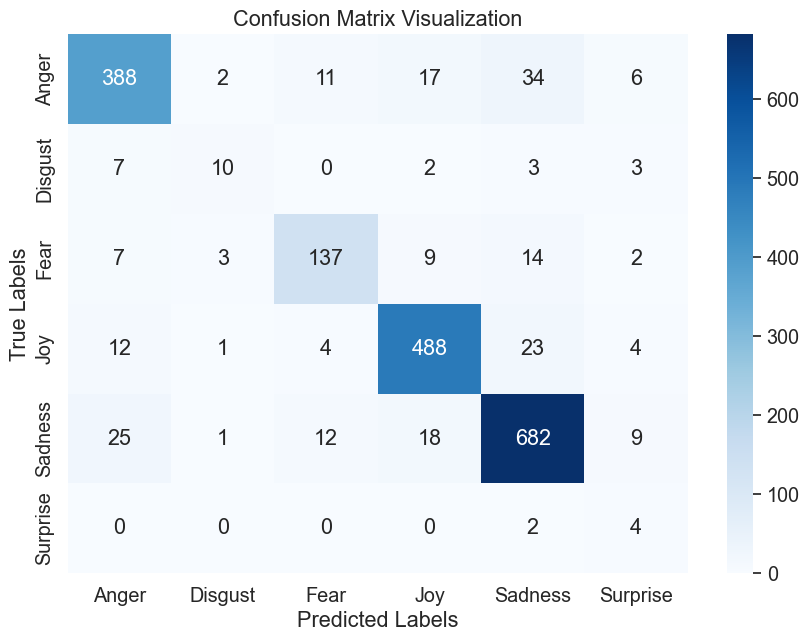

In [20]:
print("TF-IDF - Random Forest")
RF_accuracy = accuracy_score(y_test, y_pred_RF)
print('Accuracy: ', RF_accuracy,'\n')

print('RF')
print(classification_report(y_test, y_pred_RF))

cm = confusion_matrix(y_test, y_pred_RF)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Visualization')
plt.show()

### Saving the model

In [21]:
joblib.dump(RF, 'RF_model.pkl')

['RF_model.pkl']

In [61]:
#load the model
RF1 = joblib.load('RF_model.pkl')
s = "غضب"
# if to cheak if input has an Arabic word
RF1.predict([s])

array(['anger'], dtype=object)

#### BM-25

In [34]:
RF = train_model_BM_25((RandomForestClassifier()), X_train, y_train)

In [35]:
y_pred_RF=RF.predict(X_test)

BM25 - Random Forest
Accuracy:  0.8154639175257732 

RF
              precision    recall  f1-score   support

       anger       0.76      0.83      0.79       458
     disgust       0.62      0.32      0.42        25
        fear       0.81      0.70      0.75       172
         joy       0.91      0.81      0.85       532
     sadness       0.83      0.86      0.84       747
    surprise       0.10      0.50      0.16         6

    accuracy                           0.82      1940
   macro avg       0.67      0.67      0.64      1940
weighted avg       0.83      0.82      0.82      1940



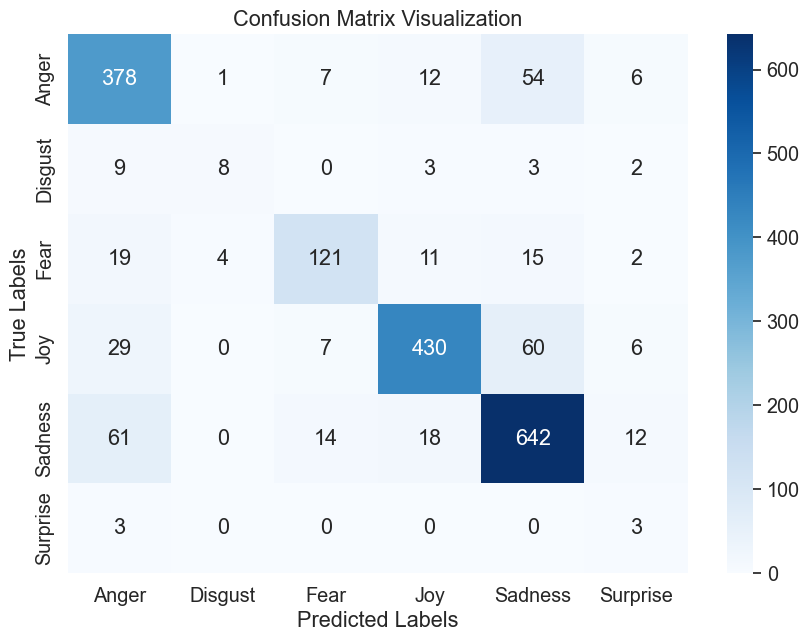

In [36]:
print("BM25 - Random Forest")
RF_accuracy = accuracy_score(y_test, y_pred_RF)
print('Accuracy: ', RF_accuracy,'\n')

print('RF')
print(classification_report(y_test, y_pred_RF))

cm = confusion_matrix(y_test, y_pred_RF)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Visualization')
plt.show()

### Word2Vec

In [37]:
RF = train_model_word2vec((RandomForestClassifier()), X_train, y_train)

In [38]:
y_pred_RF=RF.predict(X_test)

Word2Vec - Random Forest
Accuracy:  0.7737113402061856 

RF
              precision    recall  f1-score   support

       anger       0.72      0.79      0.75       458
     disgust       1.00      0.28      0.44        25
        fear       0.64      0.61      0.62       172
         joy       0.89      0.78      0.83       532
     sadness       0.80      0.82      0.81       747
    surprise       0.08      0.50      0.14         6

    accuracy                           0.77      1940
   macro avg       0.69      0.63      0.60      1940
weighted avg       0.79      0.77      0.78      1940



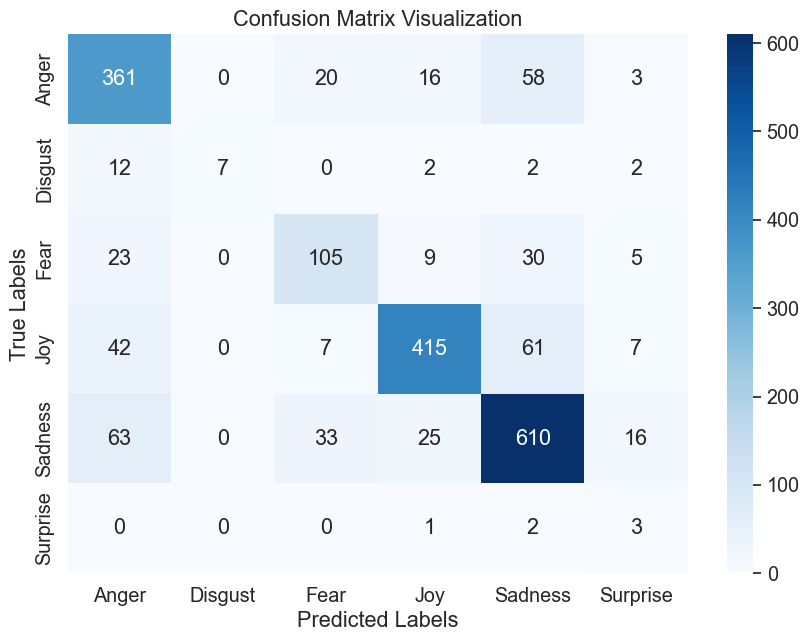

In [39]:
print("Word2Vec - Random Forest")
RF_accuracy = accuracy_score(y_test, y_pred_RF)
print('Accuracy: ', RF_accuracy,'\n')

print('RF')
print(classification_report(y_test, y_pred_RF))

cm = confusion_matrix(y_test, y_pred_RF)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Visualization')
plt.show()

### SVM model

#### TF-IDF

In [26]:
svm = train_model_IDF((SVC(kernel="poly")), X_train, y_train)

In [27]:
y_pred_svm = svm.predict(X_test)

TF-IDF - SVM
Accuracy: SVM 0.8902061855670103 

SVM
              precision    recall  f1-score   support

       anger       0.97      0.82      0.89       458
     disgust       1.00      0.44      0.61        25
        fear       0.98      0.68      0.80       172
         joy       0.96      0.91      0.93       532
     sadness       0.81      0.99      0.89       747
    surprise       0.80      0.67      0.73         6

    accuracy                           0.89      1940
   macro avg       0.92      0.75      0.81      1940
weighted avg       0.90      0.89      0.89      1940



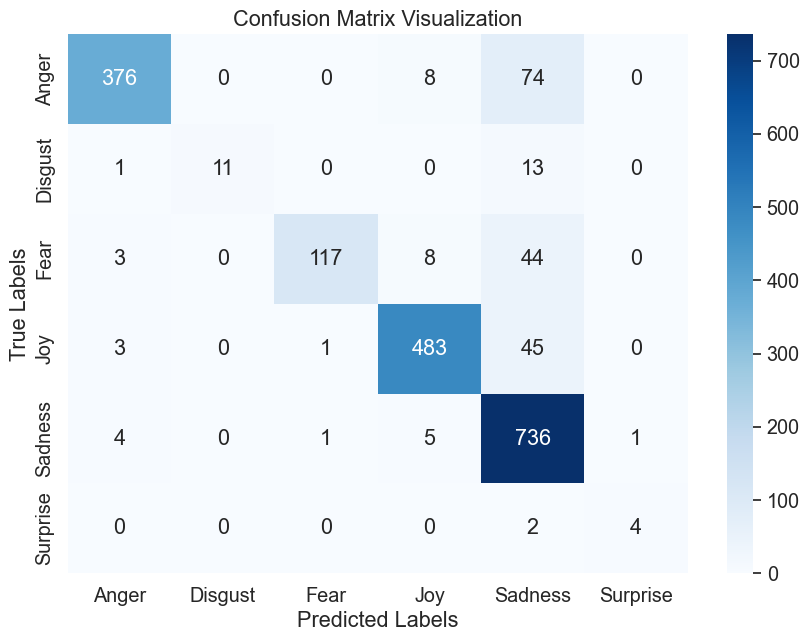

In [28]:
print("TF-IDF - SVM")
SVM_accuracy = accuracy_score(y_test, y_pred_svm)
print('Accuracy: SVM', SVM_accuracy,'\n')

print('SVM')
print(classification_report(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm)

# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Visualization')
plt.show()


### Saving the model

In [29]:
joblib.dump(svm, 'SVM_model.pkl')

['SVM_model.pkl']

In [46]:
#load the model
svm1 = joblib.load('SVM_model.pkl')
s = "انا اليوم سعيد"
# if to cheak if input has an Arabic word
svm1.predict([s])

array(['joy'], dtype=object)

Best configuration: {'ngram_range': (1, 1), 'max_df': 0.85, 'min_df': 0.01, 'kernel': 'rbf', 'accuracy': 0.4999614949043484}

#### BM-25

In [43]:
svm = train_model_BM_25((SVC(kernel="poly")), X_train, y_train)

In [44]:
y_pred_svm = svm.predict(X_test)

BM-25 - SVM
Accuracy: SVM 0.7030927835051546 

SVM
              precision    recall  f1-score   support

       anger       0.89      0.51      0.65       458
     disgust       0.43      0.12      0.19        25
        fear       0.76      0.44      0.56       172
         joy       0.96      0.64      0.77       532
     sadness       0.59      0.95      0.73       747
    surprise       0.18      0.50      0.26         6

    accuracy                           0.70      1940
   macro avg       0.63      0.53      0.53      1940
weighted avg       0.77      0.70      0.70      1940



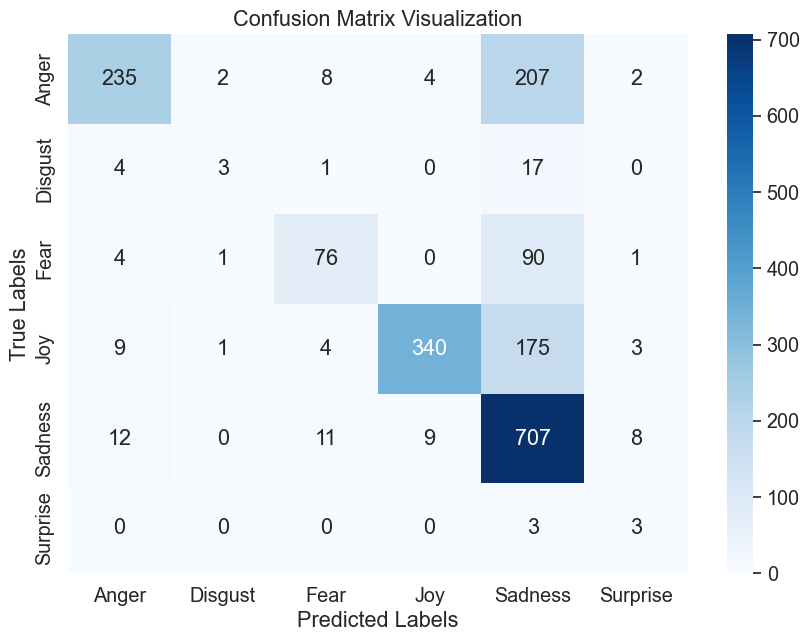

In [45]:
print("BM-25 - SVM")
SVM_accuracy = accuracy_score(y_test, y_pred_svm)
print('Accuracy: SVM', SVM_accuracy,'\n')

print('SVM')
print(classification_report(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm)

# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Visualization')
plt.show()


#### Word2Vec

In [46]:
svm = train_model_word2vec((SVC(kernel="poly")), X_train, y_train)

In [47]:
y_pred_svm=svm.predict(X_test) 

Word2Vec - SVM
Accuracy: SVM 0.49690721649484537 

SVM
              precision    recall  f1-score   support

       anger       0.35      0.79      0.49       458
     disgust       0.00      0.00      0.00        25
        fear       0.33      0.08      0.12       172
         joy       0.85      0.47      0.61       532
     sadness       0.59      0.45      0.51       747
    surprise       0.00      0.00      0.00         6

    accuracy                           0.50      1940
   macro avg       0.35      0.30      0.29      1940
weighted avg       0.57      0.50      0.49      1940



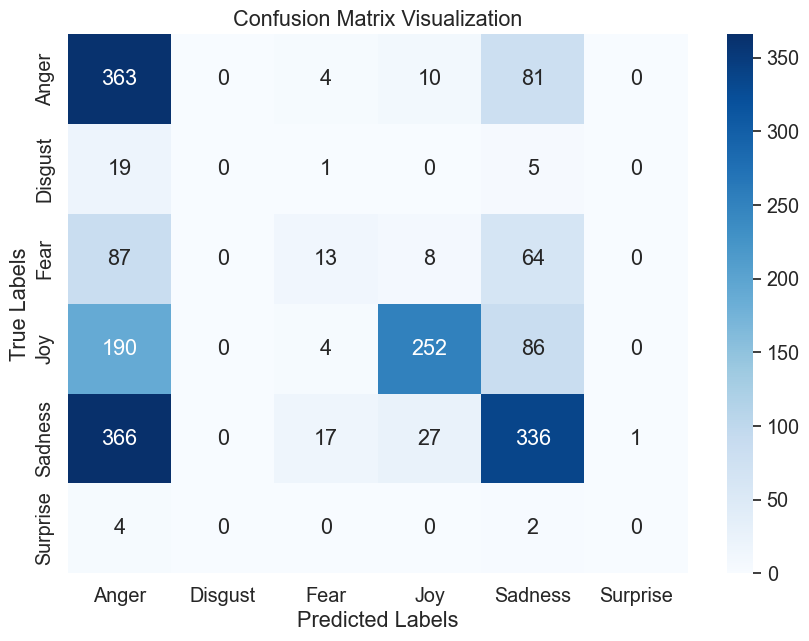

In [48]:
print("Word2Vec - SVM")
SVM_accuracy = accuracy_score(y_test, y_pred_svm)
print('Accuracy: SVM', SVM_accuracy,'\n')

print('SVM')
print(classification_report(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm)

# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Visualization')
plt.show()

### KNN model

#### TF-IDF

In [31]:
knn = train_model_IDF((KNeighborsClassifier(n_neighbors=1, algorithm= 'auto')), X_train, y_train)
y_pred_KNN = knn.predict(X_test)

In [50]:
def replace_emojis_with_text(text):
    translated_text = ""
    for char in text:
        if any(emoji.distinct_emoji_list(char) for char in char):
            translated_text += " " + emojis.get(char, char) + " "
        else:
            translated_text += emojis.get(char, char)
    return translated_text

TF-IDF - KNN
Accuracy: KNN 0.8798969072164948 

KNN
              precision    recall  f1-score   support

       anger       0.95      0.83      0.88       458
     disgust       0.41      0.56      0.47        25
        fear       0.73      0.80      0.76       172
         joy       0.87      0.93      0.90       532
     sadness       0.93      0.91      0.92       747
    surprise       0.24      0.67      0.35         6

    accuracy                           0.88      1940
   macro avg       0.69      0.78      0.71      1940
weighted avg       0.89      0.88      0.88      1940



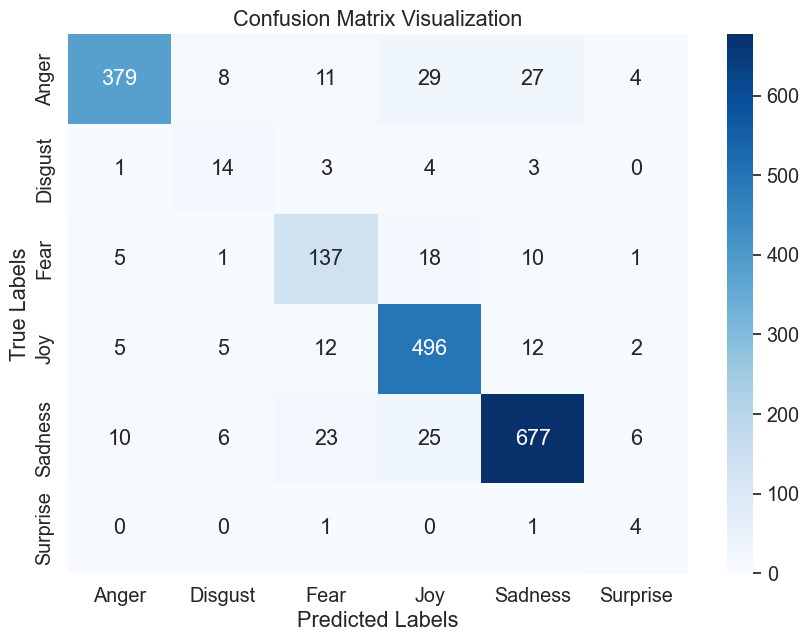

In [32]:
print("TF-IDF - KNN")
KNN_accuracy = accuracy_score(y_test, y_pred_KNN)
print('Accuracy: KNN', KNN_accuracy,'\n')

print('KNN')
print(classification_report(y_test, y_pred_KNN))

cm = confusion_matrix(y_test, y_pred_KNN)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Visualization')
plt.show()

### Saving the model

In [33]:
joblib.dump(knn, 'KNN_model.pkl')

['KNN_model.pkl']

In [6]:
#load the model
knn1 = joblib.load('KNN_model.pkl')
s1 = "بالنسبة لي تغيرت النظرة مع الازمة ربعنا عندهم روح فكاهة غير طبيعية "  
s=lemmatize_arabic_Iris(s1)
s=normalizeArabic(s)
s=remove_stop_words(s)
# if to cheak if input has an Arabic word
result=knn1.predict([s])
print(result[0]+" =",s1)

joy = بالنسبة لي تغيرت النظرة مع الازمة ربعنا عندهم روح فكاهة غير طبيعية 


#### BM-25

In [52]:
knn = train_model_BM_25((KNeighborsClassifier(n_neighbors=1, algorithm= 'brute', leaf_size = 5)), X_train, y_train)
y_pred_KNN = knn.predict(X_test)

BM-25 - KNN
Accuracy: KNN 0.8134020618556701 

KNN
              precision    recall  f1-score   support

       anger       0.87      0.78      0.82       458
     disgust       0.46      0.48      0.47        25
        fear       0.73      0.74      0.73       172
         joy       0.81      0.86      0.83       532
     sadness       0.89      0.83      0.86       747
    surprise       0.06      0.67      0.11         6

    accuracy                           0.81      1940
   macro avg       0.64      0.73      0.64      1940
weighted avg       0.84      0.81      0.82      1940



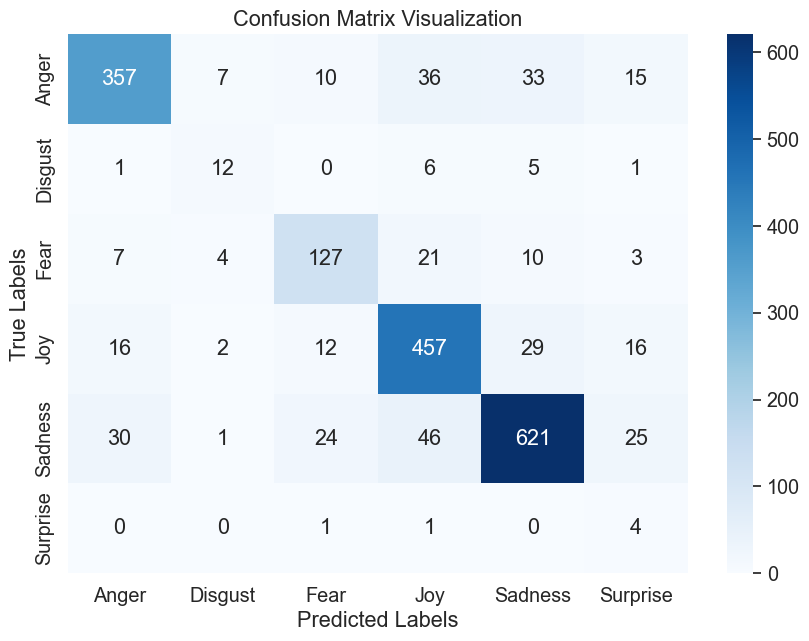

In [53]:
print("BM-25 - KNN")
KNN_accuracy = accuracy_score(y_test, y_pred_KNN)
print('Accuracy: KNN', KNN_accuracy,'\n')

print('KNN')
print(classification_report(y_test, y_pred_KNN))

cm = confusion_matrix(y_test, y_pred_KNN)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Visualization')
plt.show()

#### Word2Vec

In [54]:
knn = train_model_word2vec((KNeighborsClassifier(n_neighbors=1, algorithm= 'brute', leaf_size = 5)), X_train, y_train)
y_pred_Word2Vec = knn.predict(X_test)

Word2Vec - KNN
Accuracy: KNN 0.6932989690721649 

KNN
              precision    recall  f1-score   support

       anger       0.67      0.71      0.69       458
     disgust       0.37      0.28      0.32        25
        fear       0.53      0.66      0.59       172
         joy       0.81      0.66      0.73       532
     sadness       0.78      0.73      0.75       747
    surprise       0.03      0.50      0.06         6

    accuracy                           0.69      1940
   macro avg       0.53      0.59      0.52      1940
weighted avg       0.73      0.69      0.71      1940



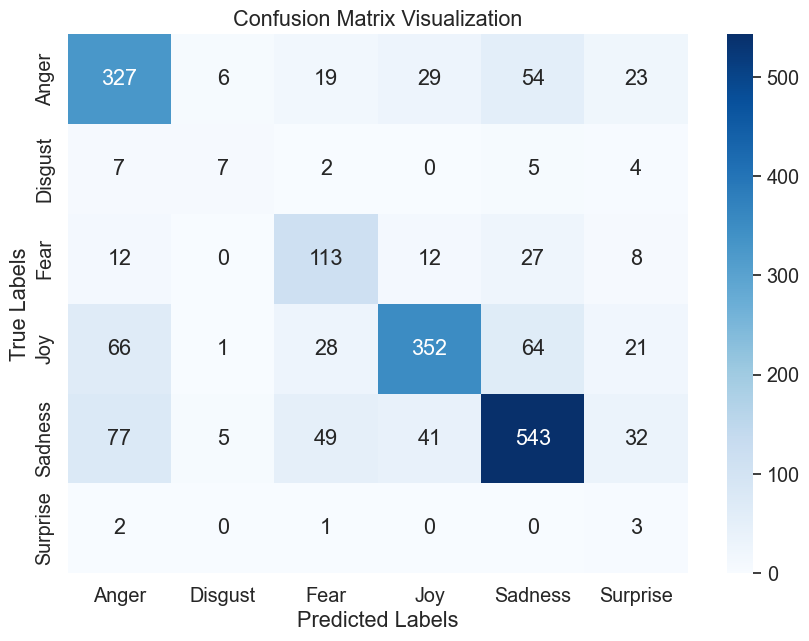

In [55]:
print("Word2Vec - KNN")
Word2Vec_accuracy = accuracy_score(y_test, y_pred_Word2Vec)
print('Accuracy: KNN', Word2Vec_accuracy,'\n')

print('KNN')
print(classification_report(y_test, y_pred_Word2Vec))

cm = confusion_matrix(y_test, y_pred_Word2Vec)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Visualization')
plt.show()

### Search for best hyper

In [127]:
# Define the pipeline
pipeline = Pipeline([
    ('vect', TfidfVectorizer(encoding='utf-8')),
    ('clf', SVC())
])

# Define the parameter grid
param_grid = {
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__min_df': [1, 2, 3, 5],
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3)],
    'vect__norm': ['l1', 'l2', None],  # Normalization applied to the TF-IDF
    'clf__C': [0.01, 0.1, 1, 10, 100, 1000],
    'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'clf__gamma': ['scale', 'auto', 0.1, 1, 10],
    'clf__degree': [2, 3, 4]  # Degree of the polynomial kernel function
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the grid search model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Get the best score and parameters
best_score = grid_search.best_score_
best_params = grid_search.best_params_

print("Best score: ", best_score)
print("Best parameters set:")
for param_name in sorted(best_params.keys()):
    print(f"{param_name}: {best_params[param_name]}")


Fitting 5 folds for each of 64800 candidates, totalling 324000 fits


KeyboardInterrupt: 

## For Fun :)

In [201]:
myTest=['عندما فتح محمد الثلاجة وشاهد بقايا الطعام المتعفنة، اجتاحه شعور بالاشمئزاز لدرجة أنه شعر بالغثيان، وتملكته الرغبة في التخلص من كل محتوياتها فوراً.',"عندي اختبار بكره ومتوتر ما ذاكرت","عبير، وهي طالعة من الدوام، لقت أخوها اللي ما شافته من سنين واقف عند الباب، طاحت عيونها من الدهشة","زعلان منهم","تقزز يوسف من رؤية الطعام الفاسد المتروك في الشمس، فانتشرت رائحة كريهة في الهواء.","يوم فتح ماجد الغرفة القديمة وشم ريحة كريهه ما تنطاق، حس بالاشمئزاز، وقفل باب الغرفة على طول وهو معفوس"] 

tt = pd.DataFrame(myTest, columns=['words'])

print(tt.words)
tt.words=tt.words.apply(lambda text : replace_emojis_with_text(text))
tt.words=tt.words.apply(lambda text : remove_stop_words(text))
tt.words=tt.words.apply(lambda text : normalizeArabic(text))
tt.words=tt.words.apply(lambda text : ISRI_Stemmer(text))

print(tt.words)


y_pred=svm.predict(tt.words)
print()
print(y_pred)
print("=================")
print(f'',list(y_test),'\n')
for i in range(len(tt.words)):
    print(tt.words[i])
    print(y_pred[i])

0    عندما فتح محمد الثلاجة وشاهد بقايا الطعام المت...
1                     عندي اختبار بكره ومتوتر ما ذاكرت
2    عبير، وهي طالعة من الدوام، لقت أخوها اللي ما ش...
3                                           زعلان منهم
4    تقزز يوسف من رؤية الطعام الفاسد المتروك في الش...
5    يوم فتح ماجد الغرفة القديمة وشم ريحة كريهه ما ...
Name: words, dtype: object
0    فتح محمد الثلاجه وشاهد بقايا الطعام المتعفنه، ...
1                             اختبار بكره ومتوتر ذاكرت
2    عبير، طالعه الدوام، لقت اللي شافته سنين واقف ا...
3                                                  زعل
4    تقزز يوسف رءيه الطعام الفاسد المتروك الشمس، فا...
5    يوم فتح ماجد الغرفه القديمه وشم ريحه كريهه تنط...
Name: words, dtype: object

['joy' 'sadness' 'sadness' 'sadness' 'disgust' 'sadness']
 ['emotion'] 

فتح محمد الثلاجه وشاهد بقايا الطعام المتعفنه، اجتاحه شعور بالاشمءزاز لدرجه شعر بالغثيان، وتملكته الرغبه التخلص محتوياتها فورا.
joy
اختبار بكره ومتوتر ذاكرت
sadness
عبير، طالعه الدوام، لقت اللي شافته سنين واقف الب

In [ ]:
#myTest=['عندما فتح محمد الثلاجة وشاهد بقايا الطعام المتعفنة، اجتاحه شعور بالاشمئزاز لدرجة أنه شعر بالغثيان، وتملكته الرغبة في التخلص من كل محتوياتها فوراً.',"عندي اختبار بكره ومتوتر ما ذاكرت","عبير، وهي طالعة من الدوام، لقت أخوها اللي ما شافته من سنين واقف عند الباب، طاحت عيونها من الدهشة","زعلان منهم","تقزز يوسف من رؤية الطعام الفاسد المتروك في الشمس، فانتشرت رائحة كريهة في الهواء.","يوم فتح ماجد الغرفة القديمة وشم ريحة كريهه ما تنطاق، حس بالاشمئزاز، وقفل باب الغرفة على طول وهو معفوس"] 





myTest=["مدري ليش، بس الجو هادي يخوفني .",
"لما أسمع أصوات غريبة بالليل أخاف .",
"كل ما أفكر في الامتحانات الجاية أتوتر .",
"أحس بقلق شديد لما أفكر في المستقبل .",
"يوم أشوف كلاب بالشارع، قلبي يدق بقوة .",
"كل ما يجي طاري الدكتور أحس بخوف .",
"الأماكن المظلمة دايم تخوفني.",
"سماع أخبار الحوادث يجيب لي القلق .",
"دايم أخاف أضيع في الأماكن الجديدة .",
"الأفلام الرعب تسوي لي كوابيس .",
"يوم أشوف الناس يتهاوشون، أخاف يصير شي سيء .",
"كل ما تجي عاصفة، أخاف من الرياح القوية .",
"العناكب والحشرات تخوفني موت .",
"لما يرن الجوال في الليل، أحس بقلبي يوقف .",
"أخاف من فكرة إني أكون لحالي بالبيت .",
"دايماً أخاف من الأخبار السيئة .",
"سماع صوت الرعد يجيب لي القلق .",
"أخاف من الأفلام اللي تعرض عمليات القتل ",
"لما أكون بالبحر وأشوف موجة كبيرة، أحس بالخوف 😱",
"يوم أفكر بالأماكن الغريبة اللي ممكن أزورها، أخاف 😰"
"لما أسمع صوت زوبعة، أخاف من العواصف الرملية."
"يوم أشوف أفلام تاريخية عن الحروب، أخاف من الصراعات."
"أخاف من فكرة الوقوع في حادث سير."
"لما أسمع خبر عن اختطاف طفل، أخاف على أخواني الصغار."
"كل ما يكون البحر هائج، أخاف من الغرق."
"أخاف من السير في الطرق الوعرة لوحدي."
"يوم يجيبون طاري الأمراض الخطيرة زي السرطان، أقلق."
"الأفلام اللي فيها مشاهد التعذيب تخليني أتوتر."
"لما أكون في مكان مجهول، أحس بالخوف."
"أخاف من الأحلام اللي فيها مخلوقات غريبة."
]


tt = pd.DataFrame(fears, columns=['words'])

print(tt.words)
tt.words=tt.words.apply(lambda text : replace_emojis_with_text(text))
tt.words=tt.words.apply(lambda text : remove_stop_words(text))
tt.words=tt.words.apply(lambda text : normalizeArabic(text))
tt.words=tt.words.apply(lambda text : Removing_punctuations(text))
tt.words=tt.words.apply(lambda text : lemmatize_arabic_Iris(text))

print(tt.words)


y_pred=RF.predict(tt.words)
print()
#print(y_pred)
print("=================")
print(f'',list(y_test),'\n')
for i in range(len(tt.words)):
    print(tt.words[i])
    print(y_pred[i])